<a href="https://colab.research.google.com/github/linghduoduo/NLP/blob/master/Chap4_MLP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

MLPs are stacked Linear layers that map tensors to other tensors. Nonlinearities are used between each pair of Linear layers to break the linear relationship and allow for the model to twist the vector space around. In a classification setting, this twisting should result in linear separability between classes. Additionally, you can use the softmax function to interpret MLP outputs as probabilities.

In [ ]:
# Multilayer perceptron using PyTorch
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights.

        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

In [ ]:
batch_size = 2 # number of samples input at once
input_dim = 3
hidden_dim = 100
output_dim = 4

# Initialize model
mlp = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
print(mlp)

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 3])
Values: 
tensor([[0.8290, 0.3947, 0.7339],
        [0.0600, 0.1093, 0.4151]])


In [ ]:
y_output = mlp(x_input, apply_softmax=False)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[-0.0911,  0.1966, -0.4767,  0.5435],
        [-0.1345,  0.1792, -0.5029,  0.4984]], grad_fn=<AddmmBackward>)


In [ ]:
y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[0.2041, 0.2721, 0.1388, 0.3850],
        [0.2023, 0.2768, 0.1400, 0.3809]], grad_fn=<SoftmaxBackward>)


In [ ]:
## Get Data Function
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'
    
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)
    
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
        
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

In [ ]:
## Visualizaing Results Function
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=100)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # plotting niceties
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
workspace_dir = './drive/My Drive/Colab Notebooks'

Mounted at /content/drive


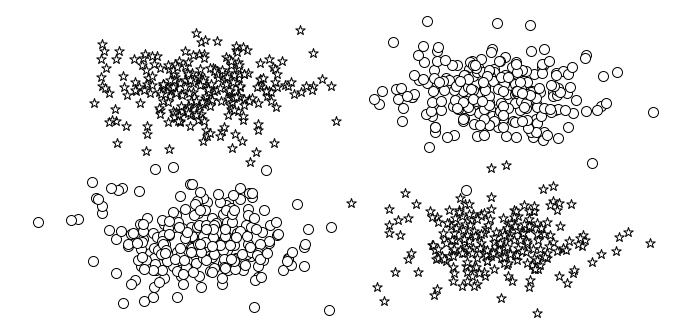

In [ ]:
## Initial Data Plot
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['black', 'white']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor='black', marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

plt.savefig("./drive/My Drive/Colab Notebooks/data.png")
plt.savefig("./drive/My Drive/Colab Notebooks/data.pdf")

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


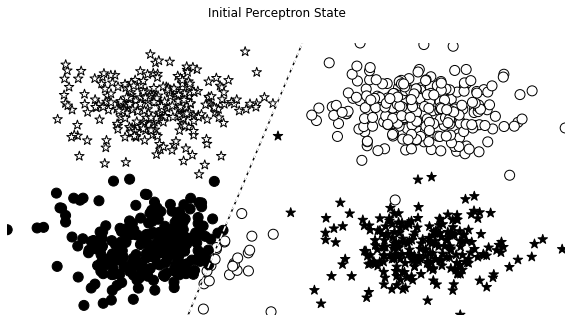

In [ ]:
## Training a Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2 # isn't ever used but we still set it


seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_hidden_layers=num_hidden_layers, 
                            output_size=output_size)
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, 
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')
plt.savefig('./drive/My Drive/Colab Notebooks/perceptron_initial.png')

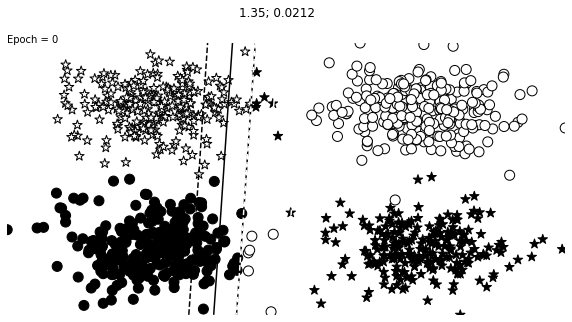

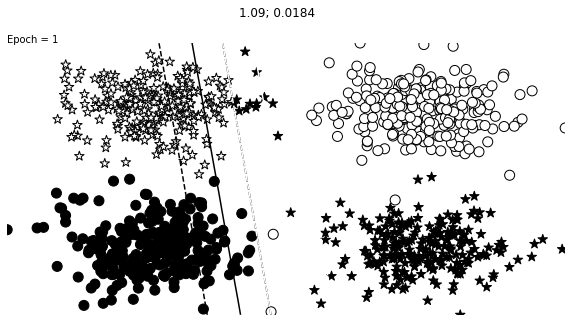

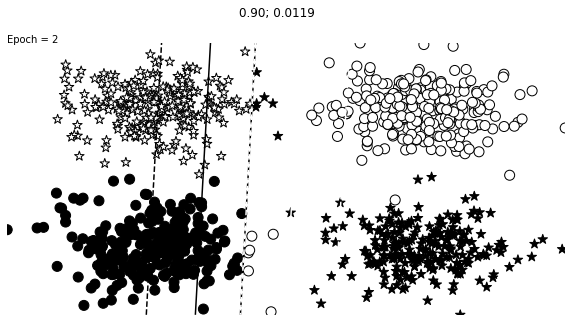

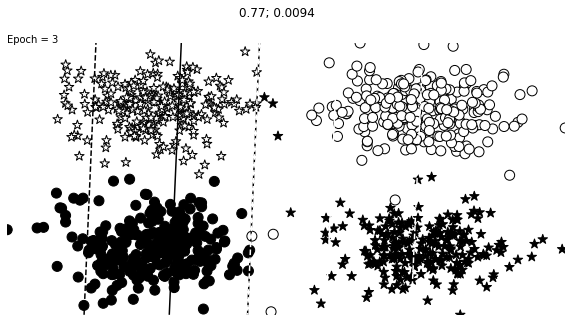

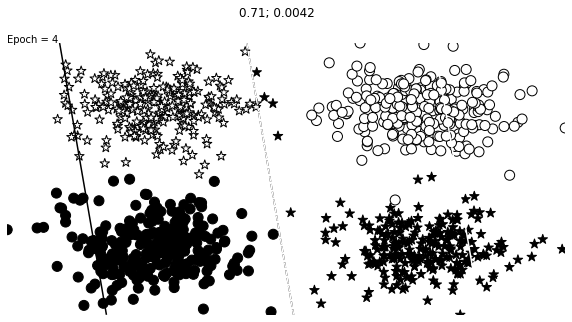

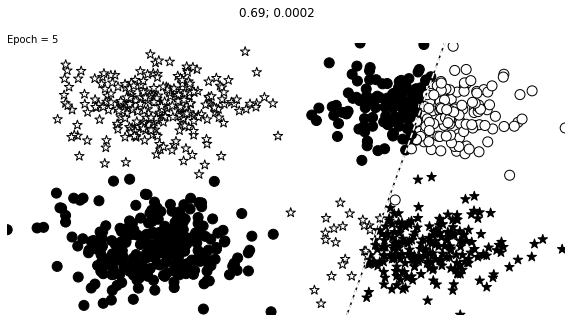

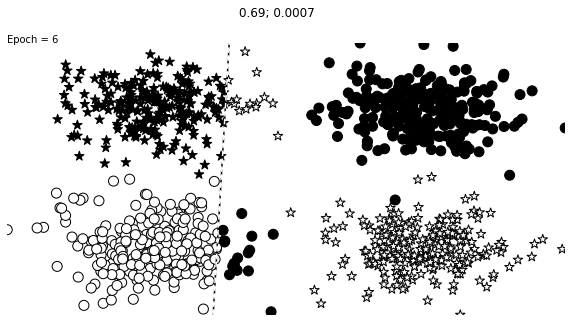

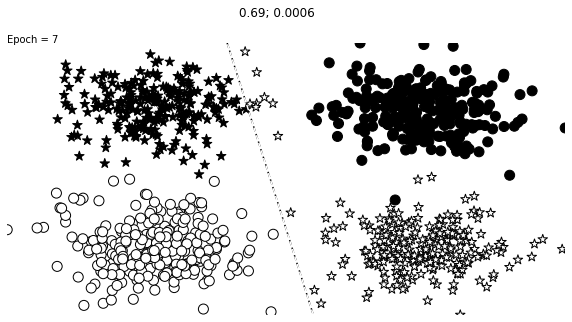

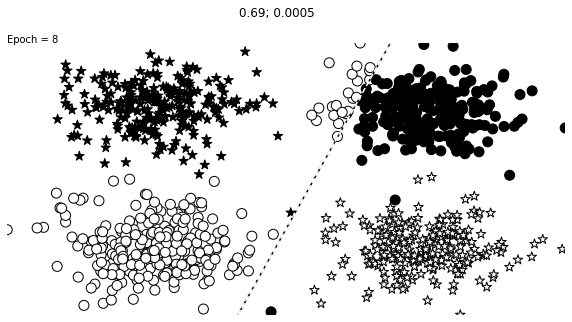

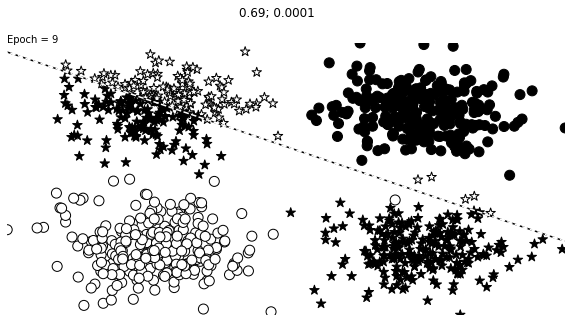

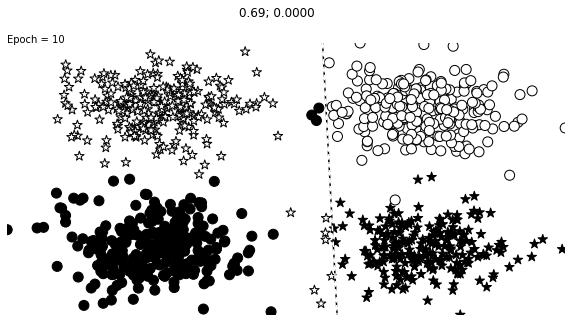

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp1.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp1(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'./drive/My Drive/Colab Notebooks/perceptron_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


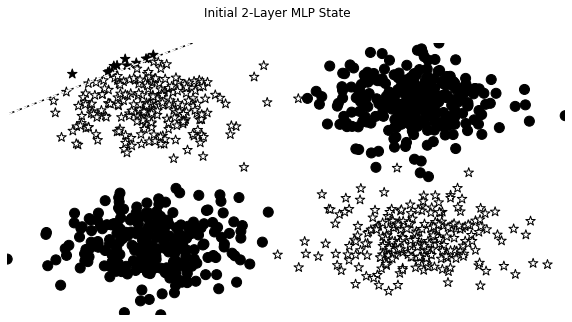

In [ ]:
## Training a 2 layer Multilayer Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
print(mlp2)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('./drive/My Drive/Colab Notebooks/mlp2_initial.png');

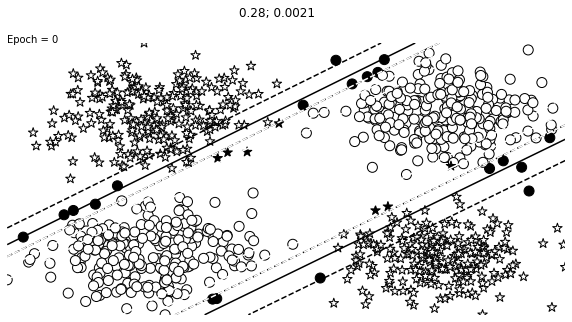

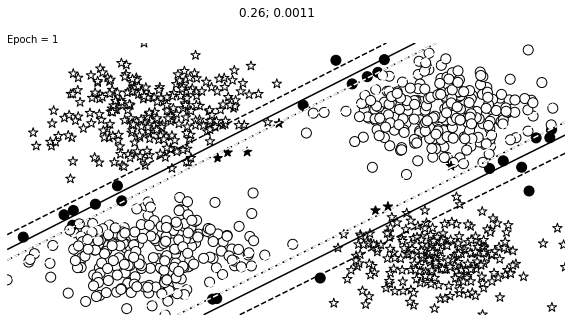

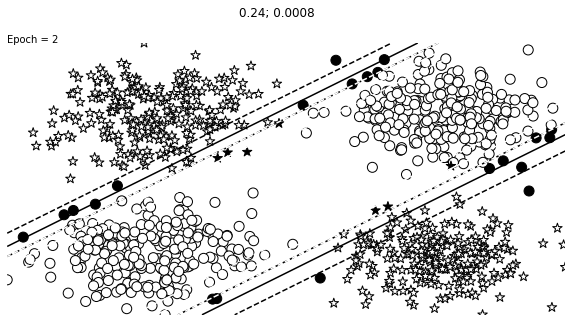

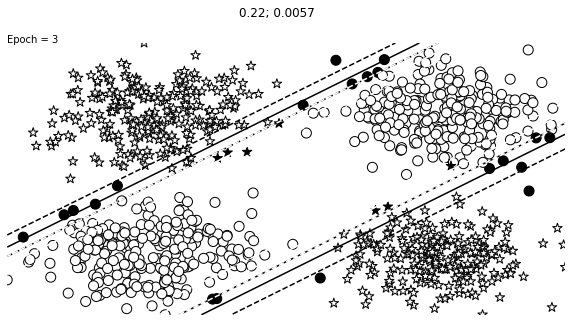

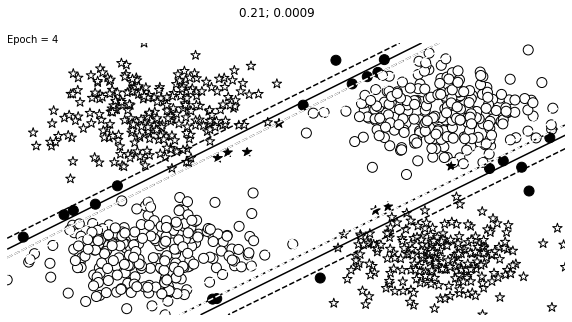

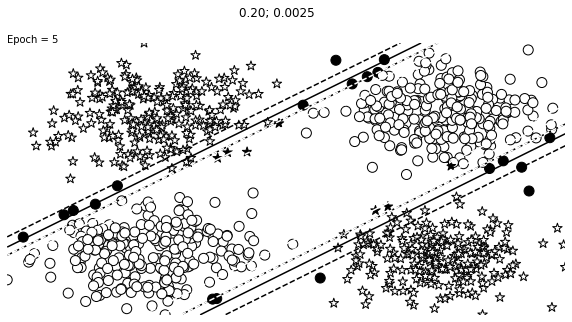

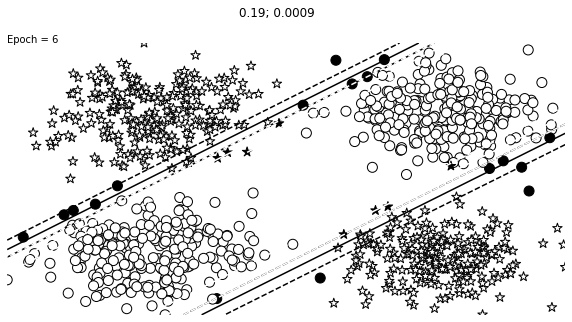

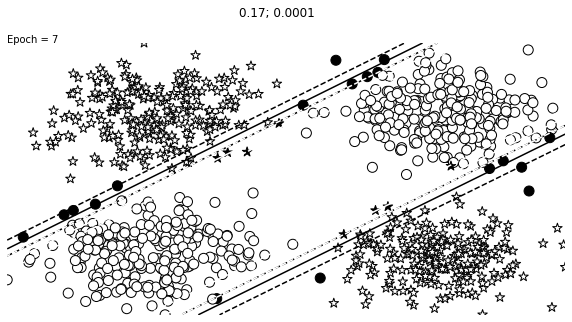

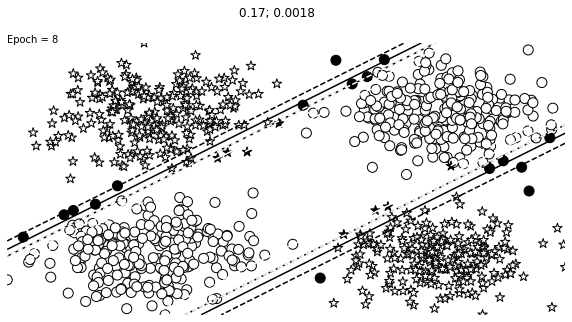

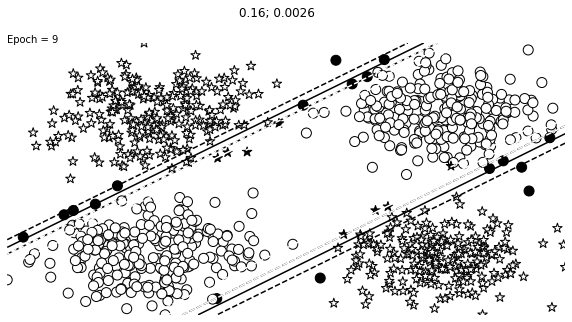

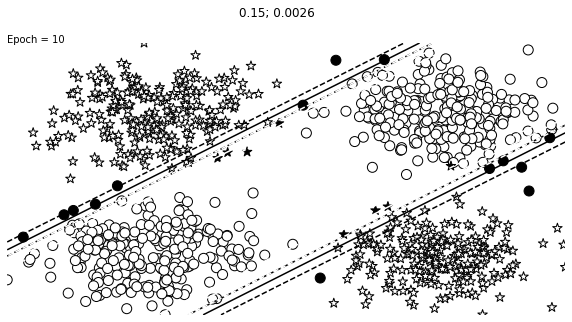

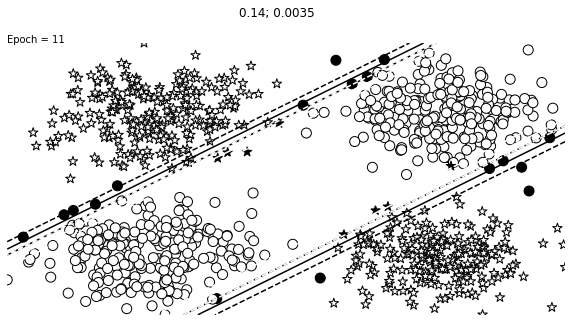

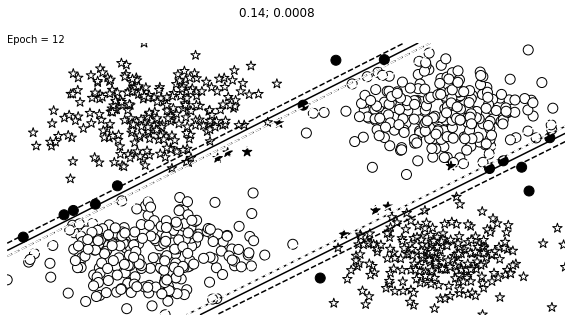

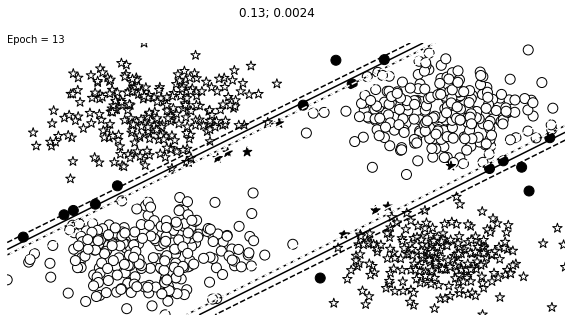

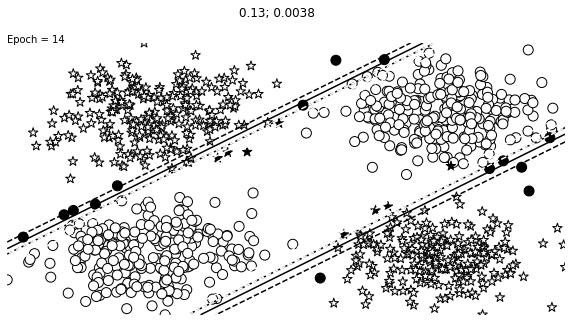

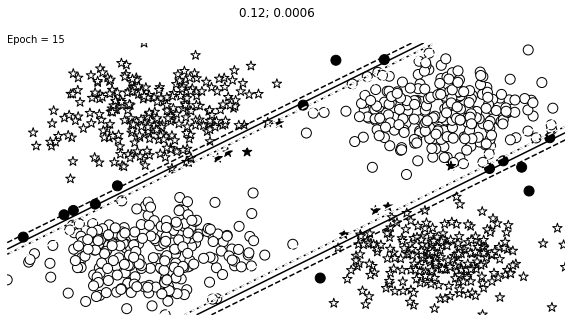

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp2.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp2(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'./drive/My Drive/Colab Notebooks/mlp2_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


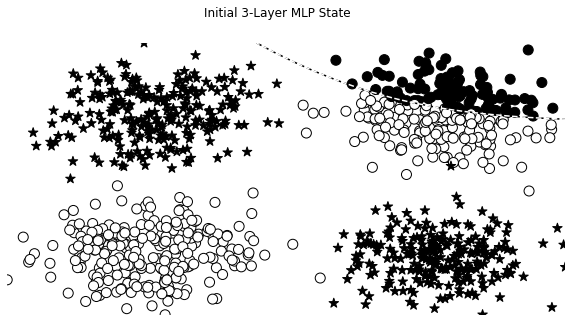

In [ ]:
## Training a 3 layer Multilayer Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 2
hidden_size = 2

seed = 399

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp3 = MultilayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
print(mlp3)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 3-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('./drive/My Drive/Colab Notebooks/mlp3_initial.png');

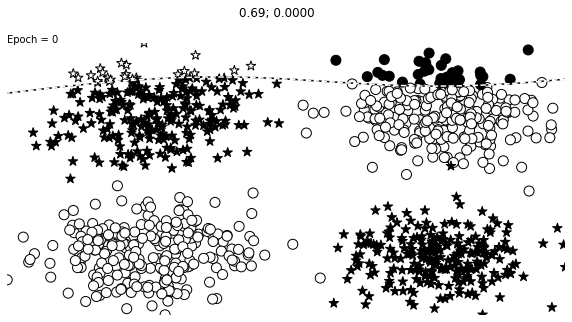

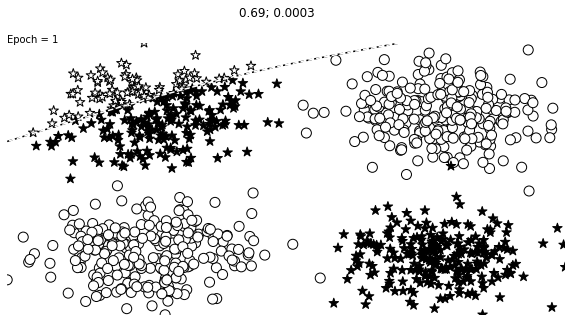

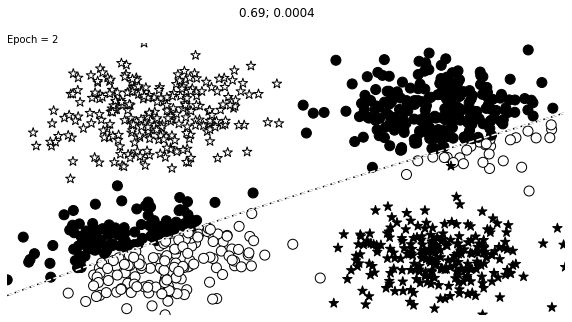

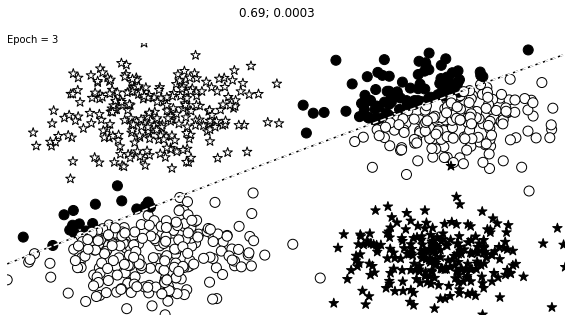

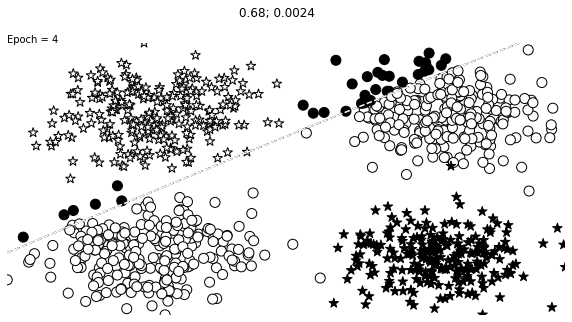

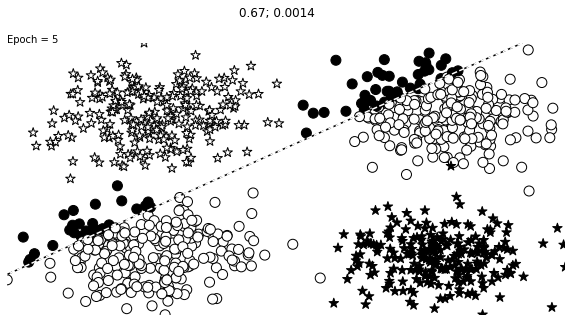

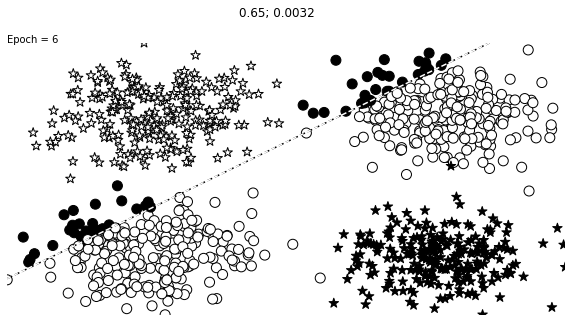

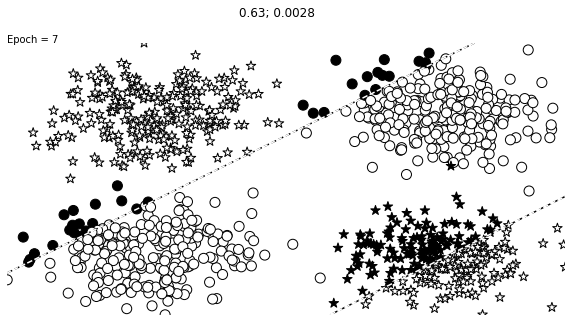

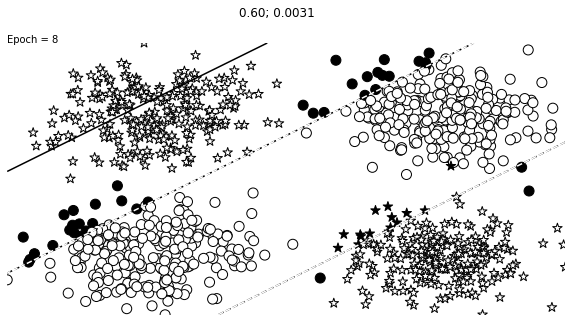

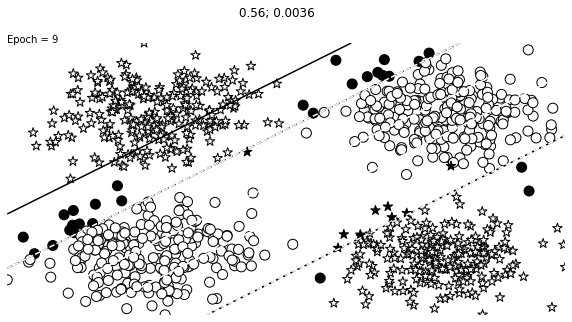

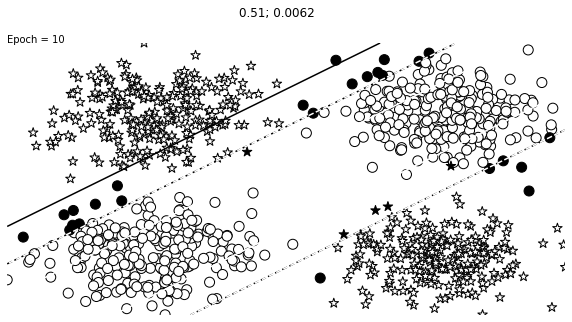

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp3.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp3.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp3(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp3, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'./drive/My Drive/Colab Notebooks/mlp3_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

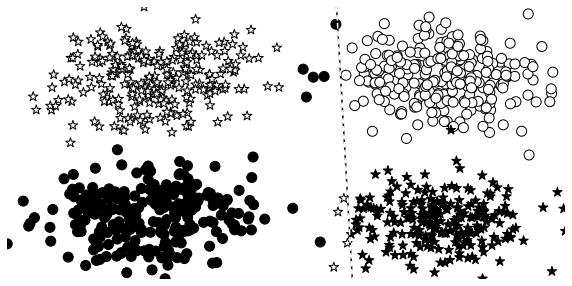

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('./drive/My Drive/Colab Notebooks/perceptron_final.png')


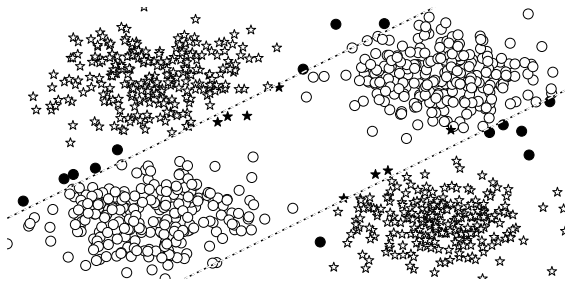

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('./drive/My Drive/Colab Notebooks/mlp2_final.png')

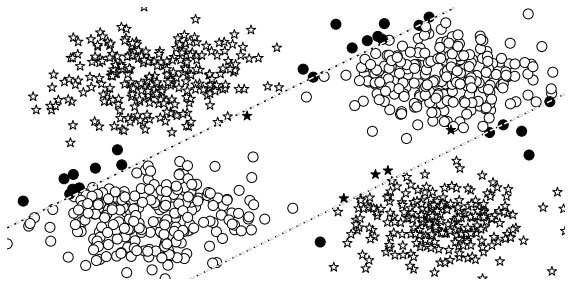

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('./drive/My Drive/Colab Notebooks/mlp3_final.png')


In [ ]:
## Inspecting the representations
batch_size = 100

def plot_intermediate_representations(mlp_model, plot_title, figsize=(10,2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).detach().numpy()

    x_data = x_data.numpy()
    y_target = y_target.numpy()

    colors = ['black', 'white'] 
    markers = ['o', '*'] 

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(x_data[data_indices,0], x_data[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
        axes[0].axis('off')
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1):
            axes[i].scatter(activations[data_indices,0], activations[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
            axes[i].axis('off')

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

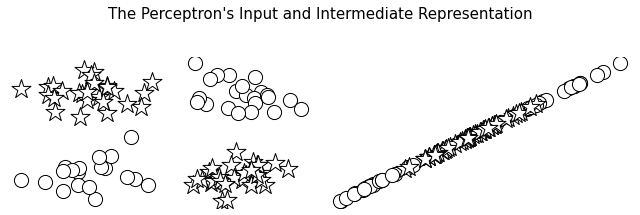

In [ ]:
plot_intermediate_representations(mlp1, 
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))
plt.savefig("./drive/My Drive/Colab Notebooks/perceptron_intermediate.png")
plt.savefig("./drive/My Drive/Colab Notebooks/figure_4_5.pdf")


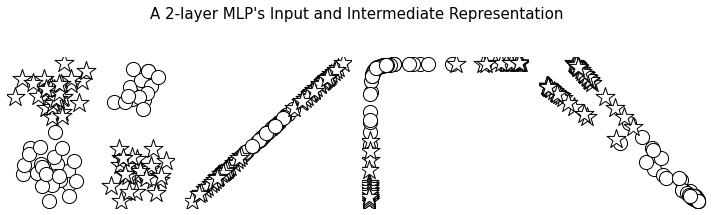

In [ ]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))
plt.savefig("./drive/My Drive/Colab Notebooks/mlp2_intermediate.png")
plt.savefig("./drive/My Drive/Colab Notebooks/figure_4_4.pdf")

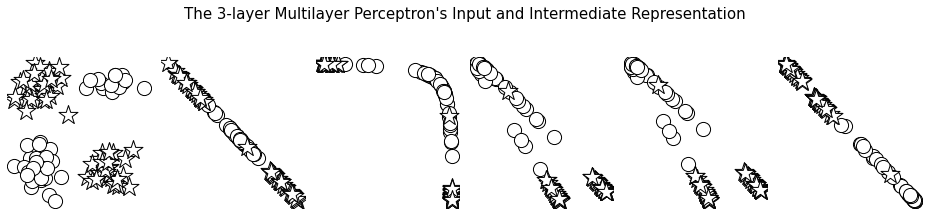

In [ ]:
plot_intermediate_representations(mlp3, 
                                  "The 3-layer Multilayer Perceptron's Input and Intermediate Representation",
                                  figsize=(13, 3))
plt.savefig("./drive/My Drive/Colab Notebooks/mlp3_intermediate.png")
plt.savefig("./drive/My Drive/Colab Notebooks/mlp3_intermediate.pdf")

## Suname Dataset

In [ ]:
import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [ ]:
args = Namespace(
    raw_dataset_csv="./drive/My Drive/Colab Notebooks/data/surnames/surnames_with_splits.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="./drive/My Drive/Colab Notebooks/data/surnames/surnames_with_splits.csv",
    seed=1337
)

In [ ]:
# Read raw data
surnames = pd.read_csv("./drive/My Drive/Colab Notebooks/data/surnames/surnames_with_splits.csv", header=0)

In [ ]:
surnames.head()

nationality  nationality_index  split   surname
0      Arabic                 15  train     Totah
1      Arabic                 15  train    Abboud
2      Arabic                 15  train  Fakhoury
3      Arabic                 15  train     Srour
4      Arabic                 15  train    Sayegh

In [ ]:
# Unique classes
set(surnames.nationality)

{'Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese'}

In [ ]:
# Splitting train by nationality
# Create dict
by_nationality = collections.defaultdict(list)
for _, row in surnames.iterrows():
    by_nationality[row.nationality].append(row.to_dict())

In [ ]:
# Create split data
args = Namespace(
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    seed=1337
)

final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [ ]:
# Write split data to file
final_surnames = pd.DataFrame(final_list)

In [ ]:
final_surnames.split.value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [ ]:
## Vocabulary
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
## Implementing SurnameVectorizer
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """Vectorize the provided surname

        Args:
            surname (str): the surname
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}    

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [ ]:
## The SurnameClassifier using an MLP
import torch.nn as nn
import torch.nn.functional as F

class SurnameClassifier(nn.Module):
    """ A 2-layer multilayer perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim).
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [ ]:
##  Hyperparameters and program options for the MLP-based Yelp review classifier
args = Namespace(
    # Data and path information
    surname_csv="./drive/My Drive/Colab Notebooks/data/surnames/surnames_with_splits.csv",
    vectorizer_file="./drive/My Drive/Colab Notebooks/data/surnamesvectorizer.json",
    model_state_file="./drive/My Drive/Colab Notebooks/data/surnamesmodel.pth",
    save_dir="./drive/My Drive/Colab Notebooks/data/surnames/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

In [ ]:
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	./drive/My Drive/Colab Notebooks/data/surnames/surname_mlp/./drive/My Drive/Colab Notebooks/data/surnamesvectorizer.json
	./drive/My Drive/Colab Notebooks/data/surnames/surname_mlp/./drive/My Drive/Colab Notebooks/data/surnamesmodel.pth
Using CUDA: False


In [ ]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab))

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

In [ ]:

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

### Inference

In [ ]:

def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).view(1, -1)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [ ]:
new_surname = input("Enter a surname to classify: ")
classifier = classifier.to("cpu")
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

### Top K Inference

In [ ]:
vectorizer.nationality_vocab.lookup_index(8)

In [ ]:
def predict_topk_nationality(name, classifier, vectorizer, k=5):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]
    
    results = []
    for prob_value, index in zip(probability_values, indices):
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        results.append({'nationality': nationality, 
                        'probability': prob_value})
    
    return results


new_surname = input("Enter a surname to classify: ")
classifier = classifier.to("cpu")

k = int(input("How many of the top predictions to see? "))
if k > len(vectorizer.nationality_vocab):
    print("Sorry! That's more than the # of nationalities we have.. defaulting you to max size :)")
    k = len(vectorizer.nationality_vocab)
    
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))